# Objective : 
Find the best the model with hghest accuracy for k-NN.

## Workflow:
1. Sort data based on time.
2. Convert reviews of "Amazon Fine Food Review" dataset into vectors using :-
    * Bag of words.
    * TF-IDF
    * Average Word2vec
    * TF-IDF Word2ves
3. Split data into train and test.
4. Find best hyperparameter by k-fold cross validation.
5. Apply k-NN model on the train data.
6. Find accuracy of the model.
7. Print confusion matrix and plot error plots for every model. 

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, gensim
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Importing data

In [2]:
"""
Reading data from .sqlite file,
choosing only positive and negative reviews not neutral reviews.
"""
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


## Cleansing data

In [3]:
"""
Below code snippet removes duplicate data from dataset that are repeatedly mentioned.
"""
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [4]:
"""
Sorting data on the basis of TIME
"""
final = final[:30000]
final = final.sort_values(by=['Time'], axis=0)
final.shape

(30000, 10)

## Text preprocessing

In [5]:
"""
This code snippet does text preprocessing
"""
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():# clean punctuation marks from words
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# verifying word must be a alphabet and atleat two character long
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):# blocks stopwords
                    s=(sno.stem(cleaned_words))# stemming in process
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [6]:
amazon_data_text = pd.Series(final_text)
amazon_data_label = pd.Series(final['Score'])
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(30000,)
(30000,)


In [7]:
"""
Spliting sample data into train_data and test_data (75:25)
"""
x_train, x_test, y_train, y_test = cross_validation.train_test_split(\
                                                                     amazon_data_text,\
                                                                     amazon_data_label,\
                                                                     test_size = 0.25,\
                                                                     random_state=0)

In [8]:
print(y_test.value_counts())

positive    6355
negative    1145
Name: Score, dtype: int64


### Bag of words.

In [9]:
"""
This code snippet converts train data from text to vectors by BOW.
"""
count_vect = CountVectorizer(analyzer='word') #in scikit-learn
bow_text_train_vector = count_vect.fit_transform(x_train)
bow_text_train_vector = bow_text_train_vector
bow_text_train_vector.shape

(22500, 20439)

In [10]:
"""
This code snippet converts test data from text to vectors by BOW.
"""
bow_text_test_vector = count_vect.transform(x_test)
bow_text_test_vector = bow_text_test_vector
print(bow_text_test_vector.shape)

(7500, 20439)



The optimal number of neighbors is 8.


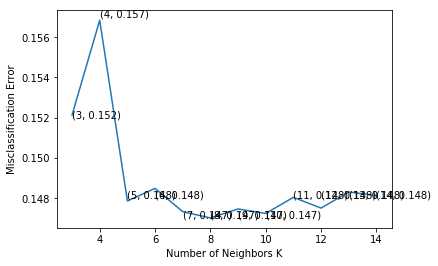

the misclassification error for each k value is :  [0.152 0.157 0.148 0.148 0.147 0.147 0.147 0.147 0.148 0.148 0.148 0.148]


In [11]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, bow_text_train_vector, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
bow_optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % bow_optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


The accuracy of the knn classifier for k = 8 is 85.066667%


Text(0.5,1,'CONFUSION MATRIX')

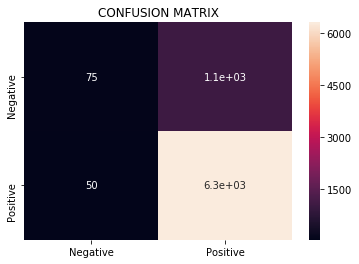

In [12]:
"""
This code snippet apply k-NN(brute force)
"""
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= bow_optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(bow_text_train_vector, y_train)
# response prediction
pred = knn_brute.predict(bow_text_test_vector)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (bow_optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix, ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier for k = 8 is 85.066667%


Text(0.5,1,'CONFUSION MATRIX')

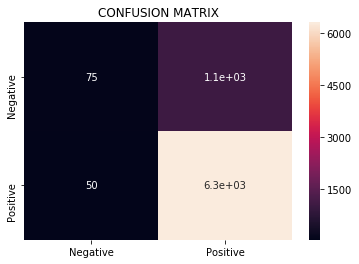

In [13]:
"""
This code snippet apply k-NN(kd tree)
"""
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= bow_optimal_k, algorithm = 'kd_tree')
# fitting the model
knn_brute.fit(bow_text_train_vector, y_train)
# response prediction
pred = knn_brute.predict(bow_text_test_vector)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (bow_optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix, ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

#### Observation :
* Here we have applied Bag of words to convert text to vector.
* We got best hyperparameter for the k-NN model is 8.
* By applying above hyperparameter in k-NN we got accuracy of 85.066667%.

### TF IDF.

In [14]:
"""
This code snippet converts train data from text to vectors by TF_IDF.
"""
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(x_train)
final_tf_idf_train.shape

(22500, 453052)

In [15]:
"""
This code snippet converts test data from text to vectors by TF_IDF.
"""
final_tf_idf_test = tf_idf_vect.transform(x_test)
final_tf_idf_test.shape

(7500, 453052)


The optimal number of neighbors is 10.


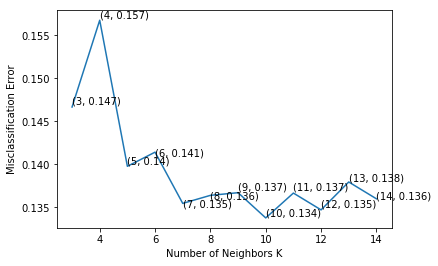

the misclassification error for each k value is :  [0.147 0.157 0.14  0.141 0.135 0.136 0.137 0.134 0.137 0.135 0.138 0.136]


In [16]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, final_tf_idf_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
tf_idf_optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % tf_idf_optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))


The accuracy of the knn classifier for k = 10 is 86.240000%


Text(0.5,1,'CONFUSION MATRIX')

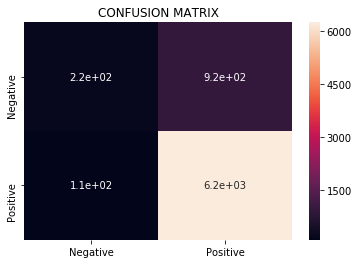

In [17]:
"""
This code snippet apply k-NN(brute force)
"""
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= tf_idf_optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(final_tf_idf_train, y_train)
# response prediction
pred = knn_brute.predict(final_tf_idf_test)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tf_idf_optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,\
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier for k = 10 is 86.240000%


Text(0.5,1,'CONFUSION MATRIX')

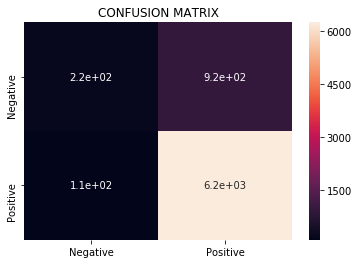

In [18]:
"""
This code snippet apply k-NN(kd tree)
"""
# Instantiate learning model
kd_tree = KNeighborsClassifier(n_neighbors= tf_idf_optimal_k, algorithm = 'kd_tree')
# fitting the model
kd_tree.fit(final_tf_idf_train, y_train)
# response prediction
pred = kd_tree.predict(final_tf_idf_test)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tf_idf_optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,\
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

#### Observation:
* Here we have applied TF IDF to convert text to vector.
* We got best hyperparameter for the k-NN model is 8.
* By applying above hyperparameter in k-NN we got accuracy of 86.240000%.

## 3) Word2Vec

In [19]:
"""
Creating own vocabulary of words from reviews.
"""
i=0
list_of_train_sent=[]
for sent in x_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_train_sent.append(filtered_sentence)
w2v_train_model=gensim.models.Word2Vec(list_of_train_sent,min_count=5,size=50, workers=4)
i=0
list_of_test_sent=[]
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_test_sent.append(filtered_sentence)
w2v_test_model=gensim.models.Word2Vec(list_of_test_sent,min_count=5,size=50, workers=4) 

### a) Average Word2Vec

In [20]:
"""
This code snippet converts train data from text to vectors by Average Word2Vec
"""
# compute average word2vec for each review.
tain_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_train_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words == 0:
        cnt_words = 1
    sent_vec /= cnt_words
    tain_vectors.append(sent_vec)
train_avg_w2v = np.asmatrix(tain_vectors)
train_avg_w2v.shape

(22500, 50)

In [21]:
"""
This code snippet converts test data from text to vectors by Average Word2Vec
"""
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_test_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words == 0:
        cnt_words = 1
    sent_vec /= cnt_words
    test_vectors.append(sent_vec)
test_avg_w2v = np.asmatrix(test_vectors)
test_avg_w2v.shape

(7500, 50)


The optimal number of neighbors is 13.


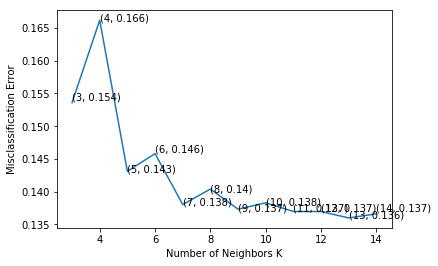

the misclassification error for each k value is :  [0.154 0.166 0.143 0.146 0.138 0.14  0.137 0.138 0.137 0.137 0.136 0.137]


In [22]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_avg_w2v, y_train, cv= 10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))


The accuracy of the knn classifier for k = 13 is 82.626667%


Text(0.5,1,'CONFUSION MATRIX')

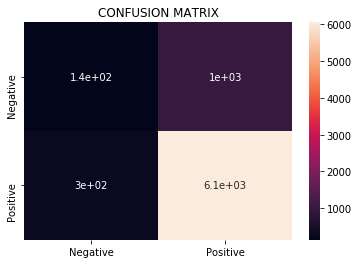

In [23]:
"""
This code snippet apply k-NN(brute force)
"""
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(train_avg_w2v, y_train)
# response prediction
pred = knn_brute.predict(test_avg_w2v)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,\
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")


The accuracy of the knn classifier for k = 13 is 82.626667%


Text(0.5,1,'CONFUSION MATRIX')

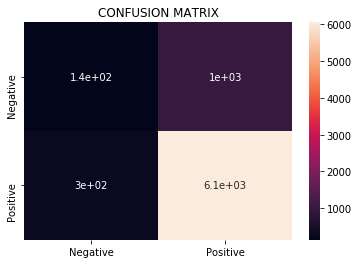

In [24]:
"""
This code snippet apply k-NN(kd tree)
"""
# Instantiate learning model
kd_tree = KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'kd_tree')
# fitting the model
kd_tree.fit(train_avg_w2v, y_train)
# response prediction
pred = kd_tree.predict(test_avg_w2v)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,\
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

#### Observation:
* Here we have applied average word2vec to convert text to vector.
* We got best hyperparameter for the k-NN model is 13.
* By applying above hyperparameter in k-NN we got accuracy of 82.6266667%.

### b) TF IDF Word2Vec

In [25]:
"""
This code snippet converts train data from text to vectors by TF-IDF weighted Word2Vec
"""
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), analyzer = 'word')
final_tf_idf = tf_idf_vect.fit_transform(x_train)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_train_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum == 0:
        weight_sum = 1
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
train_tf_idf_w2v = np.asmatrix(tfidf_train_vectors)
train_tf_idf_w2v.shape

(22500, 50)

In [26]:
"""
This code snippet converts test data from text to vectors by TF-IDF weighted Word2Vec
"""
final_tf_idf = tf_idf_vect.transform(x_test)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_test_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum == 0:
        weight_sum = 1
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
test_tf_idf_w2v = np.asmatrix(tfidf_test_vectors)
test_tf_idf_w2v.shape

(7500, 50)


The optimal number of neighbors is 11.


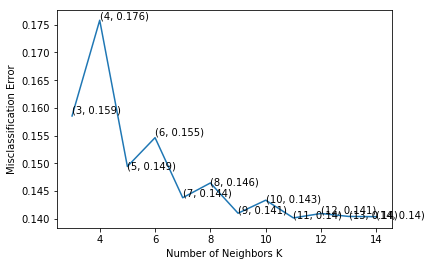

the misclassification error for each k value is :  [0.159 0.176 0.149 0.155 0.144 0.146 0.141 0.143 0.14  0.141 0.14  0.14 ]


In [27]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_tf_idf_w2v, y_train, cv= 10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))


The accuracy of the knn classifier for k = 11 is 83.080000%


Text(0.5,1,'CONFUSION MATRIX')

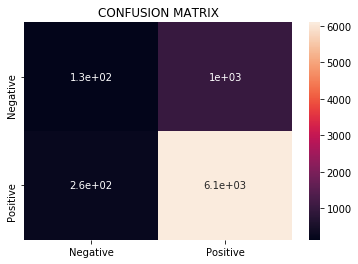

In [28]:
"""
This code snippet apply k-NN(brute force)
"""
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(train_tf_idf_w2v, y_train)
# response prediction
pred = knn_brute.predict(test_tf_idf_w2v)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,\
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")


The accuracy of the knn classifier for k = 11 is 83.080000%


Text(0.5,1,'CONFUSION MATRIX')

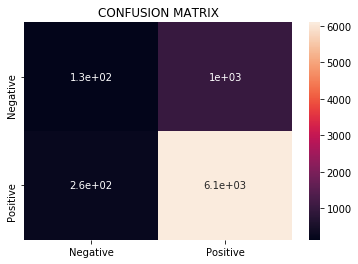

In [29]:
"""
This code snippet apply k-NN(kd tree)
"""
# Instantiate learning model
kd_tree = KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'kd_tree')
# fitting the model
kd_tree.fit(train_tf_idf_w2v, y_train)
# response prediction
pred = kd_tree.predict(test_tf_idf_w2v)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,\
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

#### Observation:
* Here we have applied TF IDF word2vec to convert text to vector.
* We got best hyperparameter for the k-NN model is 11.
* By applying above hyperparameter in k-NN we got accuracy of 83.080000%.

## Conclusion :
1. From the above analysis with 30000 sample of data I got that TF IDF is the best with accuracy 86.240000% .
2. I think with large sample of data, algorithms would have perform better because from large data large vocabulary will be build.

### Model-----Best_Hyperparameter------Accuracy
######  BOW----------------------------------8---------------------85.066667%
###### TF IDF-------------------------------10--------------------86.240000%
###### Avg word2vec--------------------13--------------------82.626667%
###### TF IDF word2vec----------------11--------------------83.080000%